In [55]:
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [41]:
rutaDogsTrain = 'cat_dog_100/train/dog'
rutaDogsTest = 'cat_dog_100/test/dog'
rutaCatsTrain = 'cat_dog_100/train/cat'
rutaCatsTest = 'cat_dog_100/test/cat'

In [37]:
from os import walk

dogTrain = []
dogTest = []
catTest = []
catTrain = []
for (dirpath, dirnames, filenames) in walk(rutaDogs):
    dogTrain.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(rutaDogsTest):
    dogTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTest):
    catTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTrain):
    catTrain.extend(filenames)

In [4]:
print(f'{rutaDogs}/{dogTrain[0]}')

cat_dog_100/train/dog/dog.10000.jpg


In [5]:
tamano = 500
sizeVentana = 16
tamano = int(tamano/sizeVentana)*sizeVentana

In [7]:
def recorta_imagen(imagen, n):
    """
    Esta función recibe una imagen y un tamaño n y recorta la imagen de tal manera que el número final de filas/columnas 
    sea múltiplo de n. La funció debe recortar las filas de la derecha/abajo.
    """
    size = np.min([int(imagen.shape[0]/n)*n, int(imagen.shape[1]/n)*n])
    return imagen[:size, :size]

In [8]:
def resize_image(imagen, sizeVentana, tamano, recorta=False):
    if(recorta): imagen = recorta_imagen(imagen, sizeVentana)
    imagen2 = cv2.resize(imagen, [tamano,tamano])
    return imagen2

In [9]:
def ventana_a_decimal(ventana_binario):
    return ventana_binario[0,0]*2**7+ventana_binario[0,1]*2**6+ventana_binario[0,2]*2**5+ventana_binario[1,2]*2**4+ventana_binario[2,2]*2**3+ventana_binario[2,1]*2**2+ventana_binario[2,0]*2+ventana_binario[1,0]

In [10]:
def transforma_bloque(celda):
    celda_ampliada = cv2.copyMakeBorder(celda, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    celda2 = np.empty(celda.shape)
    for i in range(1, celda.shape[0]+1):
        for j in range(1, celda.shape[1]+1):
            ventana = celda_ampliada[i-1:i+2, j-1:j+2]
            ventana2 = np.zeros(ventana.shape)
            pixel_central = ventana[1,1]
            ventana2[ventana>pixel_central] = 1
            celda2[i-1,j-1] = ventana_a_decimal(ventana2)
    return celda2

In [31]:
def transforma_imagen(imagen, sizeVentana, tamano):
    imagen = resize_image(imagen, sizeVentana, tamano, True)
    #imagen2 = np.zeros(imagen.shape)
    caracteristicas = []
    a = int(imagen.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celda = imagen[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            nueva_celda = transforma_bloque(celda)
            #imagen2[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana] = nueva_celda
            caracteristicas.append(cv2.calcHist([np.uint8(nueva_celda)], [0], None, [256], [0, 256]).ravel())
    return np.concatenate(caracteristicas)

In [32]:
n = 2
imagen = cv2.imread(f'{rutaDogs}/{dogTrain[n]}',0)
caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
print(caracteristicas)
print(caracteristicas.shape)
cv2.imshow(f'{dogTrain[n]}', imagen)
cv2.imshow(f'{dogTrain[n]}_transformada', np.uint8(imagen2))
cv2.waitKey(0)
cv2.destroyAllWindows()

[37.  0.  5. ...  0.  0.  3.]
(246016,)


In [42]:
X = []
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


In [43]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

Gatos Test: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]


In [45]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)

(170, 246016)


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed, GRU, SimpleRNN
import tensorflow.keras as keras

#Para ver si detecta la GPU (si no, hacer "conda install -c conda-forge cudnn" o algo así)
print(tf.config.list_physical_devices())
print("Número de GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Número de GPUs disponibles:  0


In [73]:
model = Sequential([
    Dense(64, input_shape = (246016, )),
    Dense(1, activation = 'sigmoid')
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                15745088  
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,745,153
Trainable params: 15,745,153
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.binary_crossentropy, metrics = ['acc'])

In [75]:
historico = model.fit(Xtrain, ytrain, validation_data= (Xval, yval), epochs = 16, batch_size = 100)

Epoch 1/16
2/2 [==============================] - 3s 762ms/step - loss: 565.4730 - acc: 0.4706 - val_loss: 762.2159 - val_acc: 0.4667
Epoch 2/16
2/2 [==============================] - 0s 202ms/step - loss: 380.3044 - acc: 0.6353 - val_loss: 585.2093 - val_acc: 0.5333
Epoch 3/16
2/2 [==============================] - 0s 213ms/step - loss: 648.7660 - acc: 0.4941 - val_loss: 553.5492 - val_acc: 0.5333
Epoch 4/16
2/2 [==============================] - 0s 213ms/step - loss: 403.4597 - acc: 0.5118 - val_loss: 151.7568 - val_acc: 0.4667
Epoch 5/16
2/2 [==============================] - 0s 211ms/step - loss: 190.8135 - acc: 0.5529 - val_loss: 420.6635 - val_acc: 0.4667
Epoch 6/16
2/2 [==============================] - 0s 208ms/step - loss: 235.3024 - acc: 0.5471 - val_loss: 41.5974 - val_acc: 0.7333
Epoch 7/16
2/2 [==============================] - 0s 207ms/step - loss: 36.4538 - acc: 0.8353 - val_loss: 250.1754 - val_acc: 0.5667
Epoch 8/16
2/2 [==============================] - 0s 235ms/step 

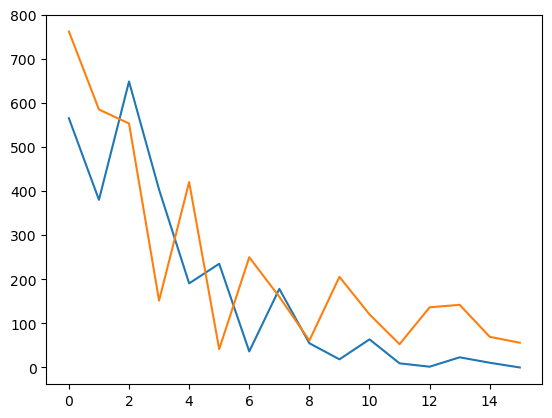

In [76]:
historial = historico.history
plt.plot(historial['loss'])
plt.plot(historial['val_loss'])

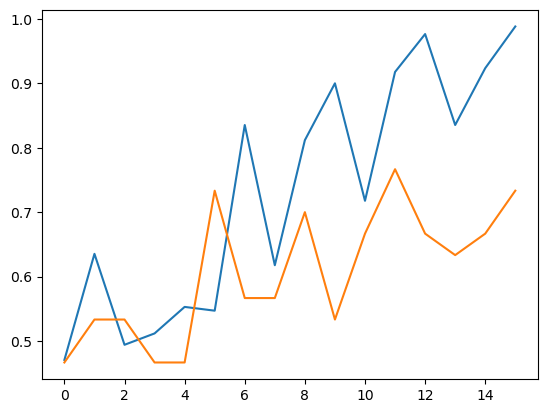

In [77]:
plt.plot(historial['acc'])
plt.plot(historial['val_acc'])

In [78]:
prediccion = model.predict(Xtest)
aciertos = np.sum(prediccion == ytest)
print(f'{aciertos/ytest.shape[0]*100 }%')

2/2 [==============================] - 4s 7ms/step
75.0%


In [89]:
# Importamos las SVMs
from sklearn import svm
# Creamos un clasificador SVM usando svm.SVC con kernel='linear', C=1.0 y máximo número de iteraciones = 1000
svc = svm.SVC(kernel = 'linear', C = 1000.0, max_iter = 10000)
svc

SVC(C=1000.0, kernel='linear', max_iter=10000)

In [90]:
# Entrenamos el modelo
svc.fit(X, y.ravel())
# Obtenemos la precisión
accTrain = svc.score(X, y)
print("Precisión en train: {}%".format(accTrain*100))

Precisión en train: 100.0%


In [91]:
print(svc.score(Xtest, ytest))

0.85
